In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import analysis
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv("Files/data.csv")
df.head(5)

,Titles,Price,Location,Rooms,Areas,Bathrooms,Listing Type,Useful area,Gross area,Construction year,Energetic certificate,Enterprise,Neighborhood,City,State
0,Apartamento T2+1 c/ Lugar de Garagem e Arrumo ...,260000.0,"Mafamude e Vilar do Paraíso, Vila Nova de Gaia...",3,106.00,2,Usado,106.00,121.0,2001,C,0,Mafamude e Vilar do Paraíso,Vila Nova de Gaia,Porto
1,Apartamento T1 para venda na Praia da Rocha,185000.0,"Portimão, Faro",1,58.30,1,Usado,58.30,68.3,2001,D,0,Portimão,Faro,NaN
2,"Apartamento T4, 2 Suítes, Luxo, Fonte Nova, Av...",950000.0,"Glória e Vera Cruz, Aveiro",4,175.00,4,Em construção,175.00,245.0,2023,A+,1,Glória e Vera Cruz,Aveiro,NaN
3,Apartamento T4,780000.0,"Vila do Conde, Porto",4,181.65,0,Em construção,181.65,207.9,0,B,1,Vila do Conde,Porto,NaN
4,Venda de Apartamento T3 duplex no centro de Vi...,300000.0,"Vila do Conde, Porto",3,183.00,2,NaN,183.00,183.0,0,D,0,Vila do Conde,Porto,NaN


In [3]:
df.describe()

,Price,Rooms,Areas,Bathrooms,Useful area,Gross area,Construction year,Enterprise
count,8.872800e+04,90000.000000,90000.000000,90000.000000,90000.000000,90000.000000,9.000000e+04,90000.000000
mean,4.066985e+05,2.351789,140.270821,1.804111,140.270776,177.082422,1.134178e+03,0.103700
std,4.375302e+05,1.001588,3182.582161,0.991427,3182.582162,4361.001389,6.838149e+03,0.304873
min,1.000000e+00,0.000000,0.110000,0.000000,0.110000,1.000000,0.000000e+00,0.000000
25%,2.070000e+05,2.000000,75.000000,1.000000,75.000000,83.000000,0.000000e+00,0.000000
50%,2.990000e+05,2.000000,100.000000,2.000000,100.000000,114.800000,1.981000e+03,0.000000
75%,4.558000e+05,3.000000,130.000000,2.000000,130.000000,153.000000,2.022000e+03,0.000000
max,3.600000e+07,10.000000,831000.000000,4.000000,831000.000000,831000.000000,2.024247e+06,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Titles                 90000 non-null  object 
 1   Price                  88728 non-null  float64
 2   Location               90000 non-null  object 
 3   Rooms                  90000 non-null  int64  
 4   Areas                  90000 non-null  float64
 5   Bathrooms              90000 non-null  int64  
 6   Listing Type           62115 non-null  object 
 7   Useful area            90000 non-null  float64
 8   Gross area             90000 non-null  float64
 9   Construction year      90000 non-null  int64  
 10  Energetic certificate  89575 non-null  object 
 11  Enterprise             90000 non-null  int64  
 12  Neighborhood           90000 non-null  object 
 13  City                   89556 non-null  object 
 14  State                  59701 non-null  object 
dtypes:

In [5]:
# Check the number of unique values in the 'Energy_Certificate' column
unique_values_ec = df['Energetic certificate'].unique()
unique_values_lt = df['Listing Type'].unique()

# Print the unique values
print(unique_values_ec)
print(unique_values_lt)

['C' 'D' 'A+' 'B' 'B-' 'E' 'A' 'Isento / Em Trâmite' 'F' nan 'G']
['Usado' 'Em construção' nan 'Novo' 'Para recuperar' 'Ruína']


In [6]:
# Drop rows with prices over 1,000,000 and less than 10000
df = df[(df['Price'] <= 1000000) & (df['Price'] >= 10000)]

# Drop rows with areas over 400 and less than 5
df = df[(df['Areas'] <= 400) & (df['Areas'] >= 5)]

# Remove rows with construction year older than 2030
df = df[df['Construction year'] <= 2030]

# Treat NaN values in 'Listing Type' as 'Usado' (used)
df['Listing Type'].fillna('Usado', inplace=True)

# Replace 0 values in 'Construction year' with NaN
df['Construction year'] = df['Construction year'].replace(0, np.nan)

# Group by 'Listing Type' and fill NaN values with the mean construction year for each group
df['Construction year'] = df.groupby('Listing Type')['Construction year'].transform(lambda x: x.fillna(x.mean()))

# If there are still NaN values after group-wise imputation, fill them with the overall mean
df['Construction year'].fillna(df['Construction year'].mean(), inplace=True)

# Update 'Construction year' for properties labeled as 'Novo' or 'Em construção' and older than 2020
df.loc[((df['Listing Type'] == 'Novo') | (df['Listing Type'] == 'Em construção')) & (df['Construction year'] < 2020), 'Construction year'] = 0

# Treat used properties with construction year more than 2023 as 'Novo' (new)
df.loc[(df['Listing Type'] == 'Usado') & (df['Construction year'] > 2023), 'Listing Type'] = 'Novo'

# Exclude rows with 'Novo' and 'Construction year' = 0
df = df[~((df['Listing Type'] == 'Novo') & (df['Construction year'] == 0))]

# Remove rows with construction year less than 1800
df = df[df['Construction year'] >= 1800]



In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83926 entries, 0 to 89999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Titles                 83926 non-null  object 
 1   Price                  83926 non-null  float64
 2   Location               83926 non-null  object 
 3   Rooms                  83926 non-null  int64  
 4   Areas                  83926 non-null  float64
 5   Bathrooms              83926 non-null  int64  
 6   Listing Type           83926 non-null  object 
 7   Useful area            83926 non-null  float64
 8   Gross area             83926 non-null  float64
 9   Construction year      83926 non-null  float64
 10  Energetic certificate  83530 non-null  object 
 11  Enterprise             83926 non-null  int64  
 12  Neighborhood           83926 non-null  object 
 13  City                   83529 non-null  object 
 14  State                  56517 non-null  object 
dtypes: floa

c:\Users\willi\anaconda3\envs\gpu\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


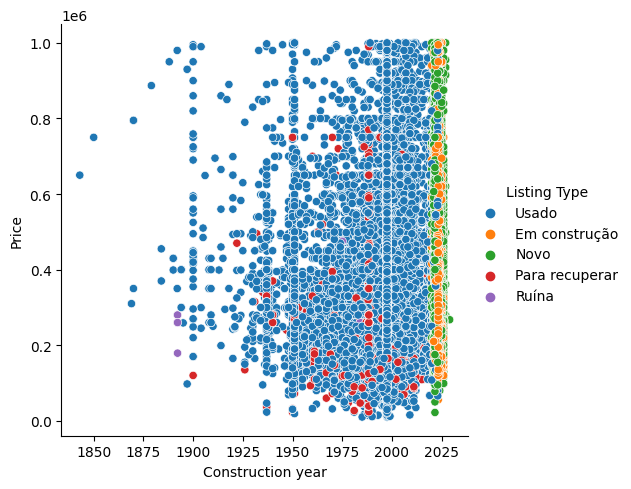

In [8]:
sns.relplot(data=df,x="Construction year", y="Price", hue="Listing Type")

In [9]:
# Fill NaN values with a default value (for example, 'Default Value')
df['Energetic certificate'].fillna('Default Value', inplace=True)

# Map the values to their numeric equivalents
certificate_mapping = {'A+': 7, 'A': 6, 'B+': 5, 'B': 4, 'B-': 3, 'C': 2, 'D': 1, 'E': 0, 'F': -1, 'G': -2, 'Isento / Em Trâmite': -3, 'Default Value': -4}

# Apply the mapping to the DataFrame
df['Energetic certificate'] = df['Energetic certificate'].map(certificate_mapping)

In [10]:
from sklearn.preprocessing import LabelEncoder

# Assuming your DataFrame is named 'df'
# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Listing Type' column to numeric values
df['Listing Type'] = label_encoder.fit_transform(df['Listing Type'])

In [11]:
df.head(5)

,Titles,Price,Location,Rooms,Areas,Bathrooms,Listing Type,Useful area,Gross area,Construction year,Energetic certificate,Enterprise,Neighborhood,City,State
0,Apartamento T2+1 c/ Lugar de Garagem e Arrumo ...,260000.0,"Mafamude e Vilar do Paraíso, Vila Nova de Gaia...",3,106.00,2,4,106.00,121.0,2001.000000,2,0,Mafamude e Vilar do Paraíso,Vila Nova de Gaia,Porto
1,Apartamento T1 para venda na Praia da Rocha,185000.0,"Portimão, Faro",1,58.30,1,4,58.30,68.3,2001.000000,1,0,Portimão,Faro,NaN
2,"Apartamento T4, 2 Suítes, Luxo, Fonte Nova, Av...",950000.0,"Glória e Vera Cruz, Aveiro",4,175.00,4,0,175.00,245.0,2023.000000,7,1,Glória e Vera Cruz,Aveiro,NaN
3,Apartamento T4,780000.0,"Vila do Conde, Porto",4,181.65,0,0,181.65,207.9,2023.274565,4,1,Vila do Conde,Porto,NaN
4,Venda de Apartamento T3 duplex no centro de Vi...,300000.0,"Vila do Conde, Porto",3,183.00,2,4,183.00,183.0,1997.501664,1,0,Vila do Conde,Porto,NaN


**Creating features**

In [12]:
# Create the Square meter per room feature
df['Square Meter per Room'] = ((df['Areas'] / df['Rooms']).replace([np.inf, -np.inf], np.nan)).round(2)

# Create the Square meter per bathroom feature
df['Square Meter per Bathroom'] = ((df['Areas'] / df['Bathrooms']).replace([np.inf, -np.inf], np.nan)).round(2)

# Replace NaN values with 0 in the 'Square_Meter_per_Room' and 'Square_Meter_per_Bathroom' columns
df['Square Meter per Room'].fillna(0, inplace=True)
df['Square Meter per Bathroom'].fillna(0, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83926 entries, 0 to 89999
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Titles                     83926 non-null  object 
 1   Price                      83926 non-null  float64
 2   Location                   83926 non-null  object 
 3   Rooms                      83926 non-null  int64  
 4   Areas                      83926 non-null  float64
 5   Bathrooms                  83926 non-null  int64  
 6   Listing Type               83926 non-null  int32  
 7   Useful area                83926 non-null  float64
 8   Gross area                 83926 non-null  float64
 9   Construction year          83926 non-null  float64
 10  Energetic certificate      83926 non-null  int64  
 11  Enterprise                 83926 non-null  int64  
 12  Neighborhood               83926 non-null  object 
 13  City                       83529 non-null  object 


**Creating dummies for locations features**

In [13]:
from sklearn.preprocessing import LabelEncoder

# Fill missing Listing Type with 'Usado' (used)
df['Listing Type'].fillna('Usado', inplace=True)

# Perform one-hot encoding using get_dummies
df = pd.get_dummies(df, columns=['Listing Type'])

# Label encoding using LabelEncoder
le = LabelEncoder()
df['Neighborhood_Encoded'] = le.fit_transform(df['Neighborhood'])
df['City_Encoded'] = le.fit_transform(df['City'])
df['State_Encoded'] = le.fit_transform(df['State'])

# Dropping the original categorical columns
df.drop(['Neighborhood', 'City', 'State'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83926 entries, 0 to 89999
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Titles                     83926 non-null  object 
 1   Price                      83926 non-null  float64
 2   Location                   83926 non-null  object 
 3   Rooms                      83926 non-null  int64  
 4   Areas                      83926 non-null  float64
 5   Bathrooms                  83926 non-null  int64  
 6   Useful area                83926 non-null  float64
 7   Gross area                 83926 non-null  float64
 8   Construction year          83926 non-null  float64
 9   Energetic certificate      83926 non-null  int64  
 10  Enterprise                 83926 non-null  int64  
 11  Square Meter per Room      83926 non-null  float64
 12  Square Meter per Bathroom  83926 non-null  float64
 13  Listing Type_0             83926 non-null  bool   


**Train and test split**

In [14]:
from sklearn.model_selection import train_test_split

# Define your features and target variable
X = df.drop(columns=['Price', 'City_Encoded', 'State_Encoded', "Location", "Titles"])  
y = df['Price']  # Assuming 'Price' is your target variable

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets to verify the split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (67140, 16)
X_test shape: (16786, 16)
y_train shape: (67140,)
y_test shape: (16786,)


**Standarlizing features**

In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
from sklearn.tree import DecisionTreeClassifier

# Create and train the Decision Tree model
dtree = DecisionTreeClassifier()
dtree.fit(X_train_scaled,y_train)

# Make predictions on the test set
predictions = dtree.predict(X_test_scaled)

In [18]:
# Call the analyze_precision function
analysis.evaluate_model_performance(y_test, predictions)

{'MAE': 69423.22864291671,
 'MSE': 17863441849.735016,
 'RMSE': 133654.1875503159,
 'R2': 0.4893538937843295}

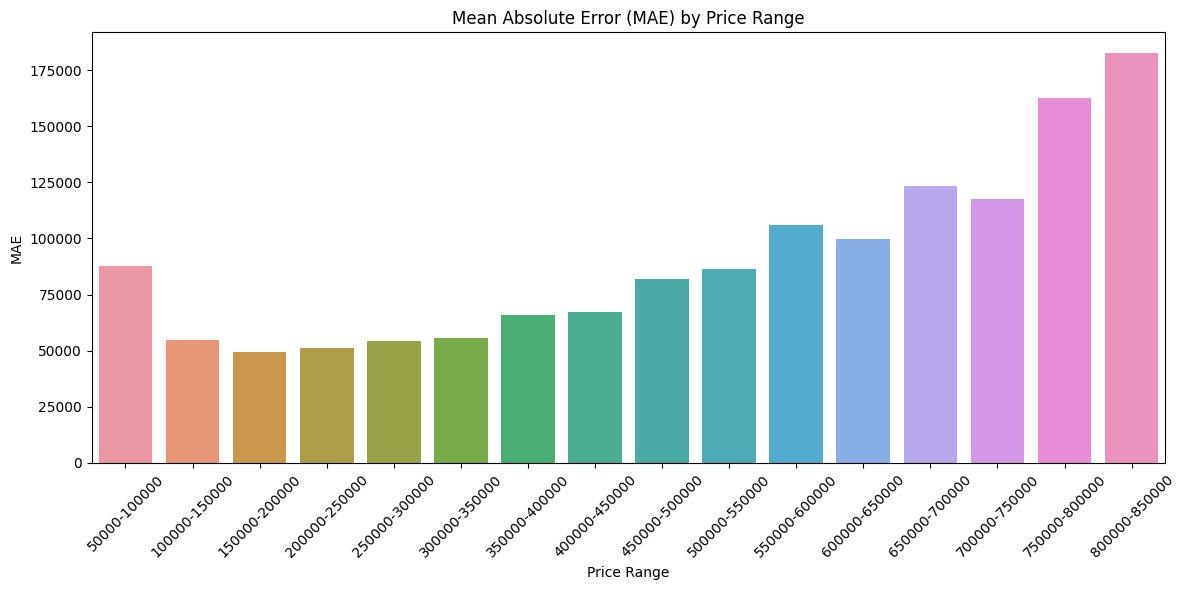

c:\Users\willi\Documents\GitHub\Predict-apartment-price-Project\Main\analysis.py:72: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Actual Values', color='blue', shade=True)
c:\Users\willi\Documents\GitHub\Predict-apartment-price-Project\Main\analysis.py:73: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions, label='Predicted Values', color='red', shade=True)


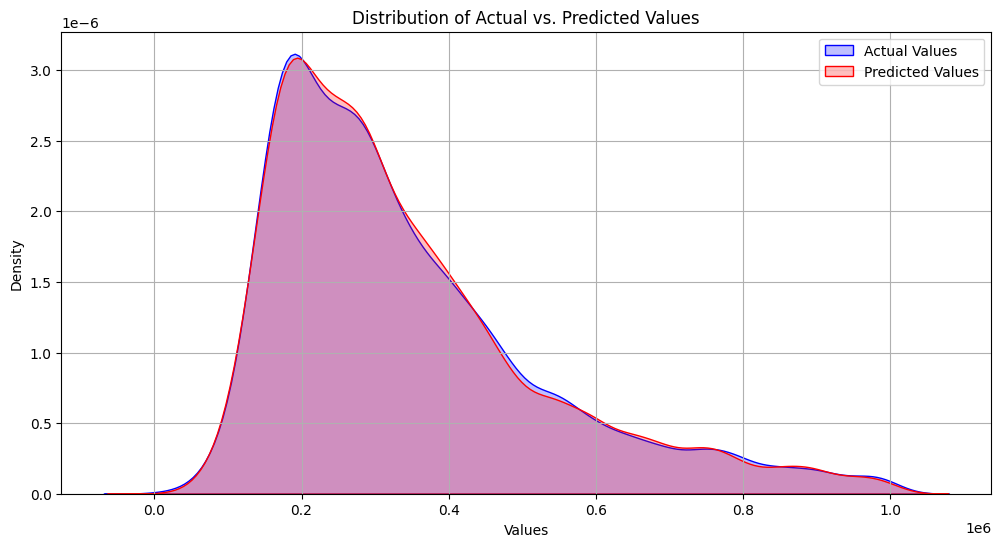

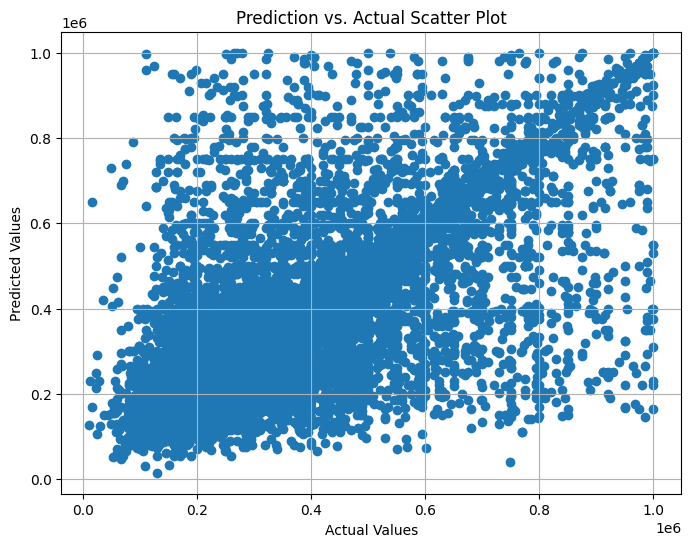

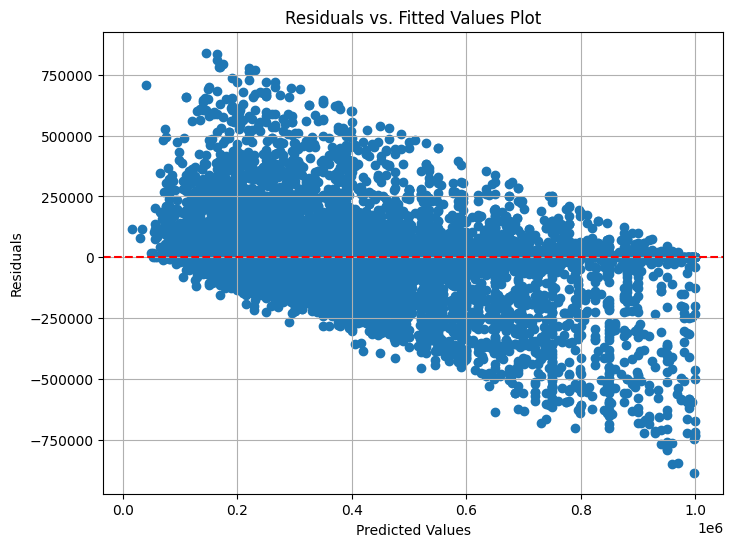

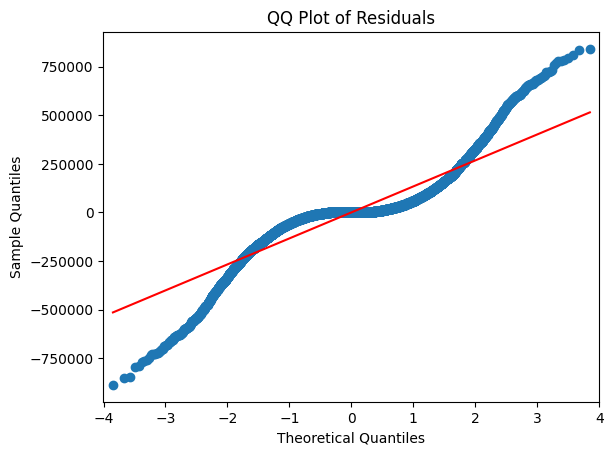

In [19]:
# Call the modified analyze_precision function
analysis.analyze_precision(X_test, y_test, predictions)